# ステップ55 CNNのメカニズム(1)
ここでは実装することを目的に画像で用いられるCNNについてメカニズムを解説\
「なぜCNNは画像を処理できるのか」「なぜ特徴量の抽出ができるのか」という理論的なところの解説はない

## 55.1 CNNのネットワーク構造
これまでのDeepLearning同様、レイヤの積み重ねからなる\
異なる点は、畳み込み層とプーリング層が登場する点のみ\
図55-1のように上記の層を含むネットワークをCNNという

## 55.2 畳み込み演算
CNNで使われる畳み込み層の処理である「畳み込み演算」を確認\
図55-3をみて計算方法について思い出そう

ちなみに、下記2点確認
- フィルタとカーネルは同じ意味で使われる
- カーネルが縦横の2方向に移動する畳み込み演算は「2次元の畳み込み層」、1方向は1次元、3方向は3次元と考える

畳み込み層にもバイアスが存在→図55-4\
バイアスの値は1つでその数値カーネルのすべての値に計算される

## 55.3 パディング
図55-5のように画像データの周囲に固定のデータを埋める処理のこと\
使用する主な理由は出力サイズの調整\
出力サイズを小さくしていく畳み込み層ではある一定のサイズを超えて小さいデータは計算できなくなってしまうので\
入力データを大きくして、出力サイズを保つ目的がある

## 55.4 ストライド
カーネルの移動間隔(マス数)→図55-6\
縦横でストライドが異なることもある(正方形でない画像などに適用)

## 55.5 出力サイズの計算方法

In [1]:
def get_conv_outsize(input_size, kernel_size, stride, pad):
    return (input_size + pad * 2 - kernel_size) // stride + 1

In [2]:
H, W = 4, 4
KH, KW = 3, 3
SH, SW = 1, 1
PH, PW = 1, 1

In [3]:
OH = get_conv_outsize(H, KH, SH, PH)
OW = get_conv_outsize(W, KW, SW, PW)
print(OH, OW)

4 4


# ステップ56 CNNのメカニズム(2)
ここでは縦横に加えて、カラー画像などで登場するチャンネルを持つ3次元データについて扱う\
その後にプーリングについて解説

## 56.1 3階テンソル
やることは2次元データの畳み込み層と同じ→図56-1\
◆注意点◆
- 図のカーネルは3枚あるということではなく、3次元のカーネルであるということ
- カーネルの縦横のサイズは自由だがチャンネル数は入力データに合わせる必要がある
- データは3次元でもカーネルの移動方向が縦横のみなので2次元の畳み込みとして扱う→出力のチャンネルは1である

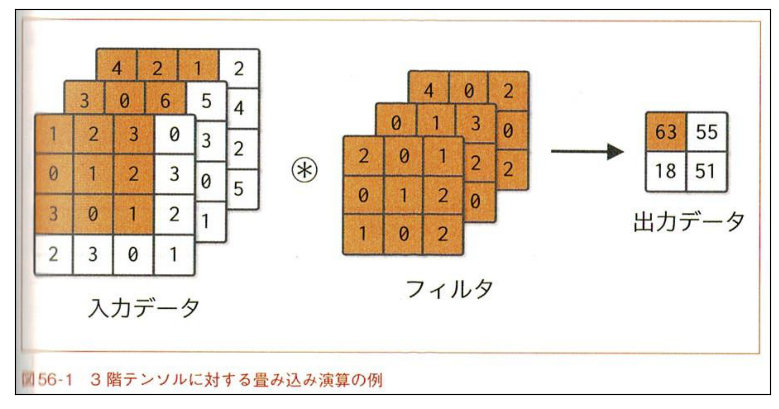

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=(10, 5))
img = plt.imread('56-1.jpg')
plt.imshow(img)
plt.gca().axes.xaxis.set_visible(False)
plt.gca().axes.yaxis.set_visible(False)
plt.show()

## 56.2 ブロックで考える
出力(特徴マップ)のチャンネルを複数持たせたいときはカーネルの種類の情報を増やしshapeを(OC, C, KH, KW)とする→図56-3\
何層目にあるかにもよるが利用時はOCが数百であるこも稀ではない\
バイアスが存在→図56-4\
バイアスはチャンネルごとに1つ数値を持ち、チャンネルごとに計算する

## 56.3 ミニバッチ処理
ここにさらにミニバッチの情報を追加\
いくつかの入力データをまとめて学習する→図56-5\
何枚の画像があるかという情報が追加されるだけで、畳み込み層自体の演算は変わらない


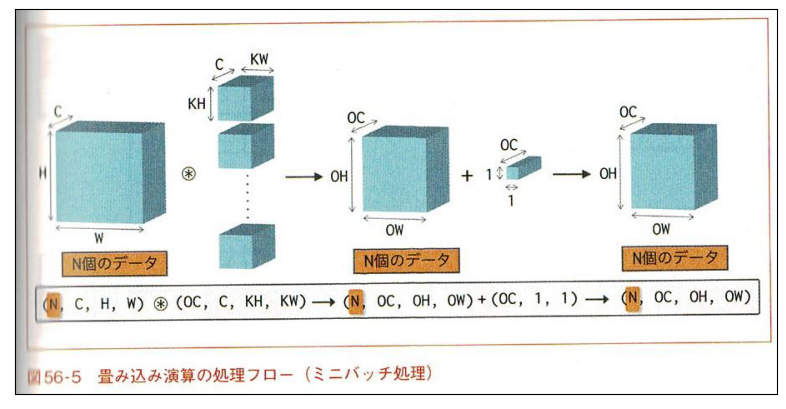

In [5]:
plt.figure(figsize=(10, 5))
img = plt.imread('56-5.jpg')
plt.imshow(img)
plt.gca().axes.xaxis.set_visible(False)
plt.gca().axes.yaxis.set_visible(False)
plt.show()

## 56.4 プーリング層
縦・横方向のサイズを小さくする処理→計算負荷考慮、過学習抑制
- マックスプーリング(画像において一般的なマックスプーリングを本書では使用)
- アベレージプーリング\
カーネルサイズ(プーリングの演算を行う範囲)とストライドを決める(一般的には両者は同じサイズ)

計算方法については図56-6

◆特徴◆
- 学習するパラメータがない→対象領域から最大値をとるだけだから
- チャンネルごとに独立して計算するのでチャンネル数は変化しない→図56−7
- 小さなズレに対しては同じような値を返すので、小さすぎる変化は同じものとして見ることができる(過学習の抑制)→図56-8

# ステップ57 Conv2d関数とpooling関数
ステップ55、ステップ56を実装していく\
カーネルをずらしながら計算するので、通常であればfor文を重ねて使うコードになるが、\
時間を使うべきはそこじゃないのでim2colという関数を利用しCNNを実装する

## 57.1 im2colによる展開
im2colの処理について見てみる→図57−1\
図ではカーネルを適用するサイズの画像データを取り出し、取り出した画像データ(多次元)を数値の並び(1次元)にリシェイプしている\
Dezeroに実装するim2colはリシェイプするかどうかを引数(to_matrix)で設定できるようにする\
畳み込み層、プーリング層の計算はこの手法が用いられるので処理流れについて理解が重要

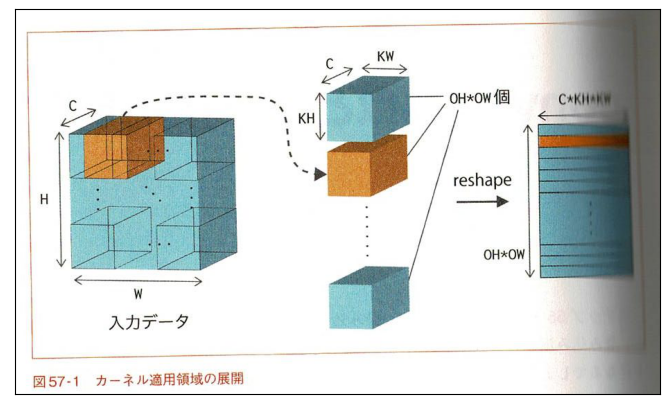

In [6]:
plt.figure(figsize=(10, 5))
img = plt.imread('57-1.jpg')
plt.imshow(img)
plt.gca().axes.xaxis.set_visible(False)
plt.gca().axes.yaxis.set_visible(False)
plt.show()

続いて、カーネルも数値のならびにリシェイプし、行列の積を計算→図57−2\
入力データをim2colしたもの：(OH✕OW, C✕KH✕KW)\
カーネルを1列に展開したもの：(C✕KH✕KW, OC)\
出力データ：(OH✕OW, OC)→チャンネルごとに幅と高さが1列に展開された状態で出力\
あとはリシェイプで演算完了

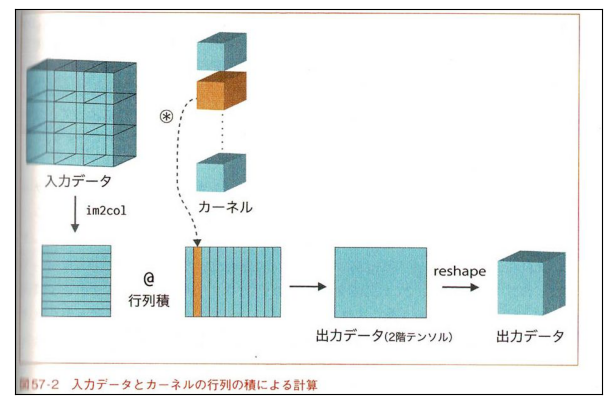

In [7]:
plt.figure(figsize=(10, 5))
img = plt.imread('57-2.jpg')
plt.imshow(img)
plt.gca().axes.xaxis.set_visible(False)
plt.gca().axes.yaxis.set_visible(False)
plt.show()

## 57.2 conv2d関数の実装
まずはim2colの処理内容を把握するがコードの中身は確認しない(見る場合はdezero/function_conv.py)\
im2col使ってみる

In [8]:
import numpy as np
import dezero.functions as F 

x1 = np.random.rand(1, 3, 7, 7) #7✕7のカラー画像データが1枚
col1 = F.im2col(x1, kernel_size=5, stride=1, pad=0, to_matrix=True)
print(col1.shape)

x2 = np.random.rand(10, 3, 7, 7) #7✕7のカラー画像データが10枚
kernel_size = (5, 5)
stride = (1, 1)
pad = (0, 0)
col2 = F.im2col(x2, kernel_size, stride, pad, to_matrix=True)
print(col2.shape)

(9, 75)
(90, 75)


kernel_sizeが5なので、入力値(x1)を(3, 5, 5)のサイズに切り分けていくと9つのデータに分けられる\
3✕5✕5=75なので75個の数値の並びが9行できることになる\
いま、9行で1枚の画像なので、それが10枚あれば90行となる

#### pair関数について
intでもtupleでも対応できるようにする関数を実装

dezero/utils.py
```python
def pair(x):
    if isinstance(x, int):
        return (x, x)
    elif isinstance(x, tuple):
        assert len(x) == 2
        return x
    else:
        raise ValueError

In [9]:
from dezero.utils import pair
print(pair(1))
print(pair((1, 2)))


(1, 1)
(1, 2)


In [10]:
# error

# print(pair((1,)))
# print(pair([1, 2]))
# print(pair((1, 2, 3)))

#### 畳み込みの計算を行う関数の実装

dezero/functions_conv.py
```python
from dezero.utils import pair, get_conv_outsize

def conv2d_simple(x, W, b=None, stride=1, pad=0):
    x, W = as_variable(x), as_variable(W) #variable型に変換

    Weight = W #重み(Weight)と幅(Width)がかぶるため
    N, C, H, W = x.shape
    OC, C, KH, KW = Weight.shape #OC:特徴マップを何枚出力するか(何種類のカーネルを使うか)
    SH, SW = pair(stride)
    PH, PW = pair(pad)
    OH = get_conv_outsize(H, KH, SH, PH) #高さについて出力サイズを計算
    OW = get_conv_outsize(W, KW, SW, PW) #幅について出力サイズを計算

    col = im2col(x, (KH, KW), stride, pad, to_matrix=True) #行方向に特徴マップの枚数、列方向に特徴(数値)の羅列 
    Weight = Weight.reshape(OC, -1).transpose() #行方向にカーネルの数値、列方向にOC
    t = linear(col, Weight, b)
    y = t.reshape(N, OH, OW, OC).transpose(0, 3, 1, 2) #transposeは図57-3のように並び替え
    return y

In [11]:
from dezero import Variable

N, C, H, W = 1, 5, 15, 15
OC, (KH, KW) = 8, (3, 3)
x = Variable(np.random.randn(N, C, H, W))
W = np.random.randn(OC, C, KH, KW)
y = F.conv2d_simple(x, W, b=None, stride=1, pad=1)
y.backward()
print(y.shape)
print(x.grad.shape)

(1, 8, 15, 15)
(1, 5, 15, 15)


ちなみにfunction_conv.pyではconv2d_simpleではなく\
Functionクラスを継承してConv2dクラスとして実装されている

参考までに\
dezero/functions_conv.py
```python
class Conv2d(Function):
    def __init__(self, stride=1, pad=0):
        super().__init__()
        self.stride = pair(stride)
        self.pad = pair(pad)

    def forward(self, x, W, b):
        xp = cuda.get_array_module(x)

        KH, KW = W.shape[2:]
        col = im2col_array(x, (KH, KW), self.stride, self.pad, to_matrix=False)

        y = xp.tensordot(col, W, ((1, 2, 3), (1, 2, 3)))
        if b is not None:
            y += b
        y = xp.rollaxis(y, 3, 1)
        # y = np.transpose(y, (0, 3, 1, 2))
        return y

    def backward(self, gy):
        x, W, b = self.inputs
        # ==== gx ====
        gx = deconv2d(gy, W, b=None, stride=self.stride, pad=self.pad,
                      outsize=(x.shape[2], x.shape[3]))
        # ==== gW ====
        gW = Conv2DGradW(self)(x, gy)
        # ==== gb ====
        gb = None
        if b.data is not None:
            gb = gy.sum(axis=(0, 2, 3))
        return gx, gW, gb


def conv2d(x, W, b=None, stride=1, pad=0):
    return Conv2d(stride, pad)(x, W, b)


class Deconv2d(Function):
    def __init__(self, stride=1, pad=0, outsize=None):
        super().__init__()
        self.stride = pair(stride)
        self.pad = pair(pad)
        self.outsize = outsize

    def forward(self, x, W, b):
        xp = cuda.get_array_module(x)

        Weight = W
        SH, SW = self.stride
        PH, PW = self.pad
        C, OC, KH, KW = Weight.shape
        N, C, H, W = x.shape
        if self.outsize is None:
            out_h = get_deconv_outsize(H, KH, SH, PH)
            out_w = get_deconv_outsize(W, KW, SW, PW)
        else:
            out_h, out_w = pair(self.outsize)
        img_shape = (N, OC, out_h, out_w)

        gcol = xp.tensordot(Weight, x, (0, 1))
        gcol = xp.rollaxis(gcol, 3)
        y = col2im_array(gcol, img_shape, (KH, KW), self.stride, self.pad,
                         to_matrix=False)
        # b, k, h, w
        if b is not None:
            self.no_bias = True
            y += b.reshape((1, b.size, 1, 1))
        return y

    def backward(self, gy):
        x, W, b = self.inputs

        # ==== gx ====
        gx = conv2d(gy, W, b=None, stride=self.stride, pad=self.pad)
        # ==== gW ====
        f = Conv2DGradW(self)
        gW = f(gy, x)
        # ==== gb ====
        gb = None
        if b.data is not None:
            gb = gy.sum(axis=(0, 2, 3))
        return gx, gW, gb


def deconv2d(x, W, b=None, stride=1, pad=0, outsize=None):
    return Deconv2d(stride, pad, outsize)(x, W, b)


class Conv2DGradW(Function):
    def __init__(self, conv2d):
        W = conv2d.inputs[1]
        kh, kw = W.shape[2:]
        self.kernel_size = (kh, kw)
        self.stride = conv2d.stride
        self.pad = conv2d.pad

    def forward(self, x, gy):
        xp = cuda.get_array_module(x)

        col = im2col_array(x, self.kernel_size, self.stride, self.pad,
                           to_matrix=False)
        gW = xp.tensordot(gy, col, ((0, 2, 3), (0, 4, 5)))
        return gW

    def backward(self, gys):
        x, gy = self.inputs
        gW, = self.outputs

        xh, xw = x.shape[2:]
        gx = deconv2d(gy, gW, stride=self.stride, pad=self.pad,
                      outsize=(xh, xw))
        ggy = conv2d(x, gW, stride=self.stride, pad=self.pad)
        return gx, ggy

## 57.3 Conv2dレイヤの実装
これまでのconvの処理をLayerとして実装\
注意すべきはin_channelがNoneかどうか\
Noneでない場合は、入力されたin_channelに従って重みのサイズを決定し初期化\
Noneの場合は、forward処理で入力値から自動で取得する

```python
class Conv2d(Layer):
    def __init__(self, out_channels, kernel_size, stride=1,
                 pad=0, nobias=False, dtype=np.float32, in_channels=None):
     
        super().__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.stride = stride
        self.pad = pad
        self.dtype = dtype

        self.W = Parameter(None, name='W')
        if in_channels is not None:
            self._init_W()

        if nobias:
            self.b = None
        else:
            self.b = Parameter(np.zeros(out_channels, dtype=dtype), name='b')

    def _init_W(self, xp=np):
        C, OC = self.in_channels, self.out_channels
        KH, KW = pair(self.kernel_size)
        scale = np.sqrt(1 / (C * KH * KW))
        W_data = xp.random.randn(OC, C, KH, KW).astype(self.dtype) * scale
        self.W.data = W_data

    def forward(self, x):
        if self.W.data is None:
            self.in_channels = x.shape[1]
            xp = cuda.get_array_module(x)
            self._init_W(xp)

        y = F.conv2d(x, self.W, self.b, self.stride, self.pad)
        return y

## 57.4 pooling関数の実装
conv2d同様im2colで展開して計算\
conv2dではチャンネル方向も含め対象の3次元データを1列に並べたが\
poolingではチャンネルごとに独立して並べる→図57-4\
※カーネルサイズ、ストライドは2✕2の例\
※チャンネルごとに行方向に並べられている


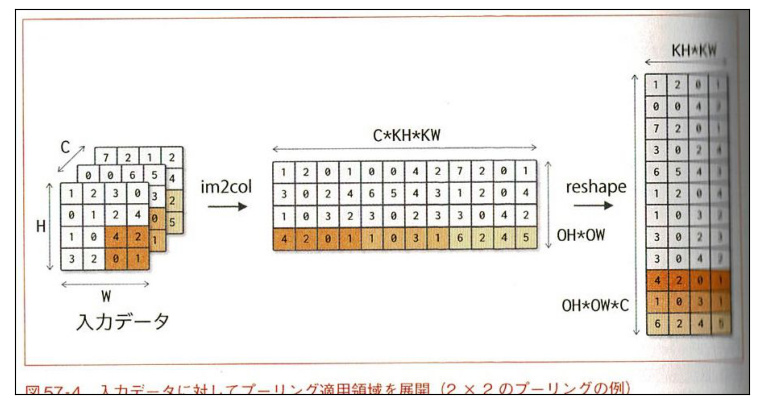

In [12]:
plt.figure(figsize=(10, 5))
img = plt.imread('57-4.jpg')
plt.imshow(img)
plt.gca().axes.xaxis.set_visible(False)
plt.gca().axes.yaxis.set_visible(False)
plt.show()

このように展開することで、あとは行ごとの最大値(平均値)を取得するだけになる→図57-5

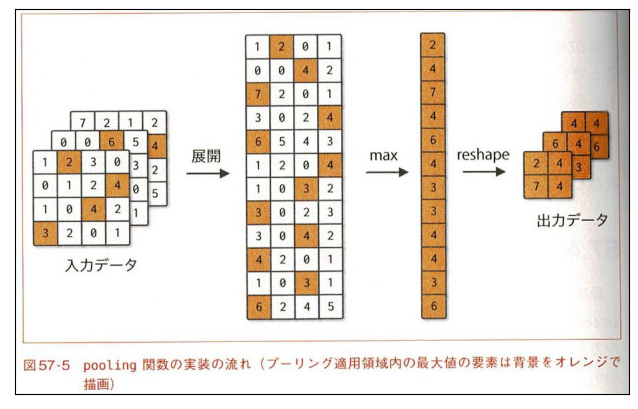

In [14]:
plt.figure(figsize=(10, 5))
img = plt.imread('57-5.jpg')
plt.imshow(img)
plt.gca().axes.xaxis.set_visible(False)
plt.gca().axes.yaxis.set_visible(False)
plt.show()

dezero/functions_conv.py
```python
def pooling_simple(x, kernel_size, stride=1, pad=0):
    x = as_variable(x)

    N, C, H, W = x.shape
    KH, KW = pair(kernel_size)
    PH, PW = pair(pad)
    SH, SW = pair(stride)
    OH = get_conv_outsize(H, KH, SH, PH)
    OW = get_conv_outsize(W, KW, SW, PW)

    col = im2col(x, kernel_size, stride, pad, to_matrix=True)
    col = col.reshape(-1, KH * KW)
    y = col.max(axis=1)
    y = y.reshape(N, OH, OW, C).transpose(0, 3, 1, 2)
    return y


参考までに、、、
```python
class Pooling(Function):
    def __init__(self, kernel_size, stride=1, pad=0):
        super().__init__()
        self.kernel_size = kernel_size
        self.stride = stride
        self.pad = pad

    def forward(self, x):
        col = im2col_array(x, self.kernel_size, self.stride, self.pad,
                           to_matrix=False)

        N, C, KH, KW, OH, OW = col.shape
        col = col.reshape(N, C, KH * KW, OH, OW)
        self.indexes = col.argmax(axis=2)
        y = col.max(axis=2)
        return y

    def backward(self, gy):
        return Pooling2DGrad(self)(gy)


class Pooling2DGrad(Function):
    def __init__(self, mpool2d):
        self.mpool2d = mpool2d
        self.kernel_size = mpool2d.kernel_size
        self.stride = mpool2d.stride
        self.pad = mpool2d.pad
        self.input_shape = mpool2d.inputs[0].shape
        self.dtype = mpool2d.inputs[0].dtype
        self.indexes = mpool2d.indexes

    def forward(self, gy):
        xp = cuda.get_array_module(gy)

        N, C, OH, OW = gy.shape
        N, C, H, W = self.input_shape
        KH, KW = pair(self.kernel_size)

        gcol = xp.zeros((N * C * OH * OW * KH * KW), dtype=self.dtype)

        indexes = (self.indexes.ravel()
                   + xp.arange(0, self.indexes.size * KH * KW, KH * KW))
        
        gcol[indexes] = gy.ravel()
        gcol = gcol.reshape(N, C, OH, OW, KH, KW)
        gcol = xp.swapaxes(gcol, 2, 4)
        gcol = xp.swapaxes(gcol, 3, 5)

        gx = col2im_array(gcol, (N, C, H, W), self.kernel_size, self.stride,
                          self.pad, to_matrix=False)
        return gx

    def backward(self, ggx):
        f = Pooling2DWithIndexes(self.mpool2d)
        return f(ggx)


class Pooling2DWithIndexes(Function):
    def __init__(self, mpool2d):
        self.kernel_size = mpool2d.kernel_size
        self.stride = mpool2d.stride
        self.pad = mpool2d.pad
        self.input_shpae = mpool2d.inputs[0].shape
        self.dtype = mpool2d.inputs[0].dtype
        self.indexes = mpool2d.indexes

    def forward(self, x):
        col = im2col_array(x, self.kernel_size, self.stride, self.pad,
                           to_matrix=False)
        N, C, KH, KW, OH, OW = col.shape
        col = col.reshape(N, C, KH * KW, OH, OW)
        col = col.transpose(0, 1, 3, 4, 2).reshape(-1, KH * KW)
        indexes = self.indexes.ravel()
        col = col[np.arange(len(indexes)), indexes]
        return col.reshape(N, C, OH, OW)


def pooling(x, kernel_size, stride=1, pad=0):
    return Pooling(kernel_size, stride, pad)(x)